In [21]:
from langchain_community.llms import Ollama
from typing import TypedDict,Annotated,Sequence,List,Union
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END,START
from langgraph.prebuilt import ToolNode

In [19]:
llm = Ollama(model="llama3.2")

In [22]:
class Agent(TypedDict):
    message : List[Union[HumanMessage,AIMessage]]

def process(state:Agent)->Agent:
    "calls llm"
    response=llm.invoke(state['message'])
    print("AI ",response.content)
    state['message'].append(AIMessage(content=response.content))
    return state

graph=StateGraph(Agent)
graph.add_node("process",process)
graph.add_edge(START,"process")
graph.add_edge("process",END)
agent=graph.compile()

conversationhistory=[]
userinput= input("Enter: ")

while userinput !="exit":
    conversationhistory.append(HumanMessage(content=userinput))
    result= agent.invoke({"message":conversationhistory})
    conversationhistory=result["message"]
    userinput= input("Enter: ")

with open("log.txt","w") as file:
    for i in conversationhistory:
        if isinstance(i,HumanMessage):
            file.write("you ",i)
        elif isinstance(i,AIMessage):
            file.write("ai ",i)



TypeError: 'dict' object is not callable

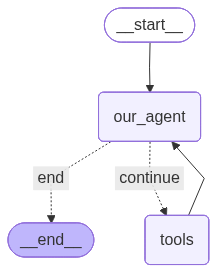

In [ ]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Always include tool_calls

input={'message':[("Add 3 + 4")]}
print_stream(app.stream(input=input,stream_mode="values"))

================================ Human Message =================================

Add 3 + 4


AttributeError: 'HumanMessage' object has no attribute 'tool_calls'